In [1]:
# import numpy, pandas and matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import cartopy
import cartopy.util as util
import cartopy.crs as ccrs
import cartopy.feature as cfeature  # features such as the ocean, coastlines rivers, etc
import cmocean

## Download the data from ISIMIP Servers:

1. Use the isimip repository portal (https://data.isimip.org/search/) to select the models/variables to download
2. After selecting the dataset, click "Download file list" at the top of the webpage
3. Move the download list onto a super computer (winSCP - windows, or using the scp command - mac/linux)
4. Go to the directory that has the download file list run the command wget -i downloadFile.txt to befin the download on the data

We can use a sample file downloaded from the ISIMIP servers located at: 
    
/glade/scratch/vgarza/test/

In [9]:
#Open the file using xarray:
file = xr.open_dataset('/glade/scratch/vgarza/test/gfdl-esm4_r1i1p1f1_historical_tos_60arcmin_global_monthly_1850_2014.nc',decode_times=False)

In [10]:
#Look at the file
file

<xarray.Dataset>
Dimensions:    (time: 1980, bnds: 2, lon: 360, lat: 180)
Coordinates:
  * time       (time) float64 2.988e+03 2.989e+03 ... 4.966e+03 4.968e+03
  * lon        (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat        (lat) float64 89.5 88.5 87.5 86.5 ... -86.5 -87.5 -88.5 -89.5
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) float64 ...
    lon_bnds   (lon, bnds) float64 ...
    lat_bnds   (lat, bnds) float64 ...
    tos        (time, lat, lon) float32 ...
Attributes: (12/47)
    CDI:                       Climate Data Interface version 1.9.6 (http://m...
    source:                    GFDL-ESM4 (2018):\natmos: GFDL-AM4.1 (Cubed-sp...
    institution:               National Oceanic and Atmospheric Administratio...
    Conventions:               CF-1.7 CMIP-6.0 UGRID-1.0
    title:                     NOAA GFDL GFDL-ESM4 model output prepared for ...
    external_variables:        areacello
    ...                        ...
    tracking_id:               hdl:21.14100/bfcce781-465e-46e9-8721-257c8a80355b
    variable_id:               tos
    variant_info:              N/A
    references:                see further_info_url attribute
    variant_label:             r1i1p1f1
    cdo_openmp_thread_number:  4

In [11]:
#Look at the shape:
np.shape(file['tos'])

(1980, 180, 360)

In [12]:
#Take the timeseries mean
time_series_mean = np.mean(file['tos'],axis=0)

TypeError: Dimensions of C (180, 360) are incompatible with X (360) and/or Y (360); see help(pcolormesh)

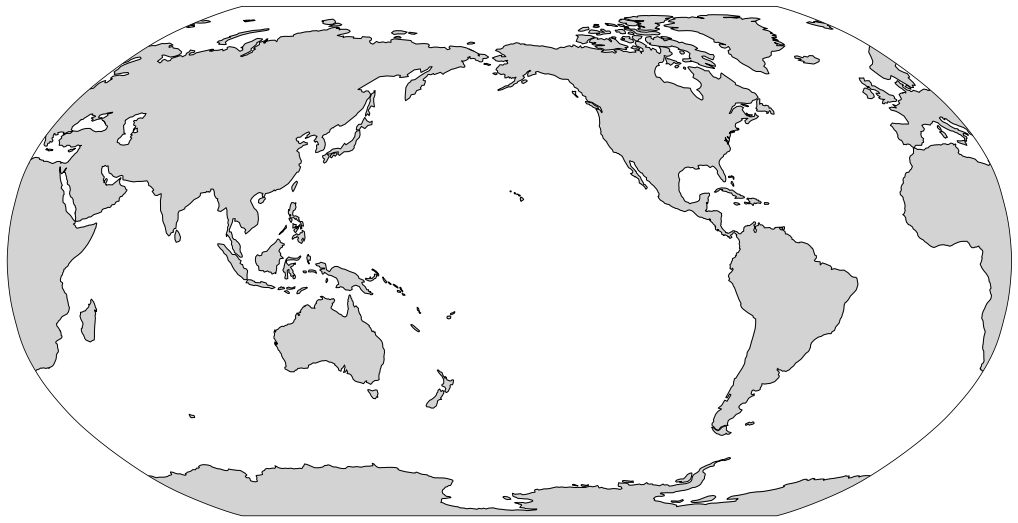

In [13]:
fig,ax= plt.subplots(figsize =(18,13),subplot_kw=dict(projection=ccrs.Robinson(central_longitude=-160)),facecolor='white')
ax.add_feature(cfeature.LAND, color = 'lightgray')
ax.add_feature(cfeature.COASTLINE)
ax.set_global()

p = plt.pcolormesh(file['lon'],file['lon'],time_series_mean,# vmin = single_min, vmax = single_max, 
                transform=ccrs.PlateCarree(),zorder=-1) # Update to: cmocean.cm.balance) in dkrz


cbar = plt.colorbar(p, orientation='horizontal', pad=0.05, fraction=0.05,ax=ax,extend=extend_2024)
cbar.ax.tick_params(labelsize=30)
cbar.set_label(var, size = 30)
plt.title('GFDL Historical Mean from 1850 - 2014',size = 35)
plt.show()
plt.close()

In [2]:
##Fix the part that is messed up and change the color limits (Only needs to be done once)
def pop_add_cyclic(ds):
    
    nj = ds.TLAT.shape[0] # size of POP grid
    ni = ds.TLONG.shape[1]

    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = ds.TLONG.data
    tlat = ds.TLAT.data
#    print('Here')    
    tlon = np.where(np.greater_equal(tlon, min(tlon[:,0])), tlon-360., tlon) #make monotoncially increasing
    lon  = np.concatenate((tlon, tlon + 360.), 1) # concatenate to make larger array
    lon = lon[:, xL:xR] #restrict to middle rane
#    print('Here')   
    if ni == 320: # this is the x1 POP grid
        print('\n')
       # lon[367:-3, 0] = lon[367:-3, 0] + 360.        #####TUPLE PROBLEM IS HERE
      #  print('Here')
    lon = lon - 360.
    
    lon = np.hstack((lon, lon[:, 0:1] + 360.)) # add in cyclic point

    if ni == 320:
        print('\n')
        #lon[367:, -1] = lon[367:, -1] - 360.  #####TUPLE PROBLEM IS HERE
        
    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    
   # lon[:, 0] = lon[:, 0] - 1e-8    ######TUPLE PROBLEM IS HERE
   
    #-- periodicity
    lat = np.concatenate((tlat, tlat), 1)
    lat = lat[:, xL:xR]
    lat = np.hstack((lat, lat[:,0:1]))

    TLAT = xr.DataArray(lat, dims=('nlat', 'nlon'))
    TLONG = xr.DataArray(lon, dims=('nlat', 'nlon'))
    
    dso = xr.Dataset({'TLAT': TLAT, 'TLONG': TLONG})
    
    # copy vars
    varlist = [v for v in ds.data_vars if v not in ['TLAT', 'TLONG']]
    for v in varlist:
        v_dims = ds[v].dims
        if not ('nlat' in v_dims and 'nlon' in v_dims):
            dso[v] = ds[v]
        else:
            # determine and sort other dimensions
            other_dims = set(v_dims) - {'nlat', 'nlon'}
            other_dims = tuple([d for d in v_dims if d in other_dims])
            lon_dim = ds[v].dims.index('nlon')
            field = ds[v].data
            field = np.concatenate((field, field), lon_dim)
            field = field[..., :, xL:xR]
            field = np.concatenate((field, field[..., :, 0:1]), lon_dim)       
            dso[v] = xr.DataArray(field, dims=other_dims+('nlat', 'nlon'), 
                                  attrs=ds[v].attrs)


    # copy coords
    for v, da in ds.coords.items():
        if not ('nlat' in da.dims and 'nlon' in da.dims):
            dso = dso.assign_coords(**{v: da})
                
            
    return dso